# Moneyball Analysis

# Part 1: Data Wrangling

Extract data from SQLite file using a SQL query. Calculate each team's winning percentage for each year and add a time period column.

In [273]:
import sqlite3
import pandas as pd
import numpy as np

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "WITH b AS (" \
               "WITH a AS (SELECT yearID, teamID, SUM(salary) AS total_payroll FROM Salaries GROUP BY yearID, teamID)" \
               "SELECT * FROM a LEFT JOIN Teams ON a.yearID = Teams.yearID AND a.teamID = Teams.teamID)" \
               "SELECT yearID, teamID, total_payroll, W, L, G, ROUND(100*(W/(W+L*1.0)),2) AS win_percentage FROM b"

team_salaries = pd.read_sql(salary_query, conn)
team_salaries = team_salaries.drop(['W','L','G'], axis=1)
# Add time periods
team_salaries['time_period'] = pd.cut(np.array(team_salaries['yearID']), 6, labels=['1985-1989','1990-1994','1995-1999','2000-2004','2005-2009','2010-2014'])
team_salaries.head()

,yearID,teamID,total_payroll,win_percentage,time_period
0,1985,ATL,14807000.0,40.74,1985-1989
1,1985,BAL,11560712.0,51.55,1985-1989
2,1985,BOS,10897560.0,50.00,1985-1989
3,1985,CAL,14427894.0,55.56,1985-1989
4,1985,CHA,9846178.0,52.47,1985-1989


I used left join, which can return missing (null) values if no rows from the right table (Teams) match any rows from the left table (Salaries).

# Part 2: EDA

Obtain subset from 1990-2014

In [274]:
team_salaries = team_salaries[team_salaries['yearID'] >= 1990]
team_salaries = team_salaries.reset_index(drop=True)
team_salaries.head()

,yearID,teamID,total_payroll,win_percentage,time_period
0,1990,ATL,14555501.0,40.12,1990-1994
1,1990,BAL,9680084.0,47.20,1990-1994
2,1990,BOS,20558333.0,54.32,1990-1994
3,1990,CAL,21720000.0,49.38,1990-1994
4,1990,CHA,9491500.0,58.02,1990-1994


Generate histograms of each year from 1990-2014 of the team payroll distributions.
Note: Each row of subplots shares the same y-axis tick values (as indicated in sharey=True).
I used the same x-axis range on each subplot in order to observe trends.

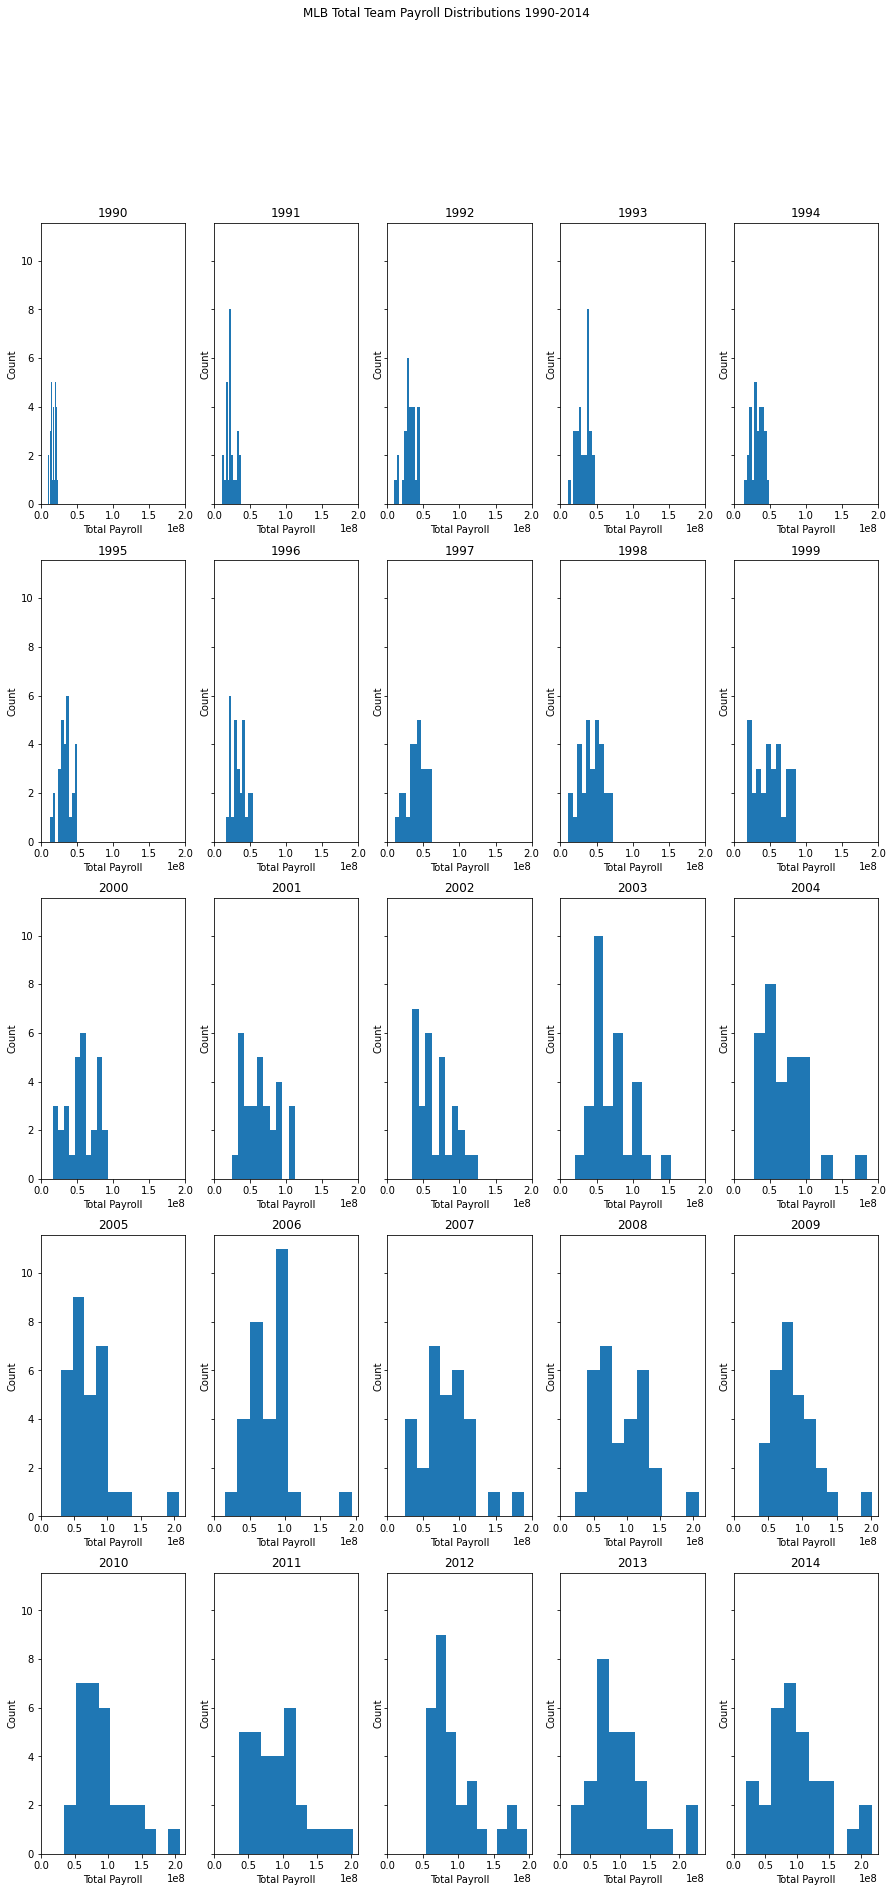

In [275]:
import matplotlib.pyplot as plt
import numpy as np

years = list(range(1990,2015))

fig, axs = plt.subplots(5, 5, figsize=(15, 30), sharey=True)

for year in years:
    index = year - 1990
    row = index // 5
    col = index % 5
    sub_df = team_salaries[team_salaries['yearID'] == year]
    y = sub_df.loc[:, 'total_payroll']
    axs[row, col].hist(y)
    axs[row, col].set_title(str(year))
    axs[row, col].set_xlabel('Total Payroll')
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_xticks(np.arange(0,2.1e8,step=5e7))

fig.suptitle('MLB Total Team Payroll Distributions 1990-2014')
plt.show()

## Observations

The average total team payrolls appear to have generally increased over the years. The distributions appear to be mostly uni-modal and most of the histograms appear relatively normal. Before 2001, the distributions of team payrolls appear mostly normal. For the later years (2001-2014), the spreads do appear somewhat right-skewed, indicating that a few select teams are spending significantly more than the rest.

Look at average total team payroll for each year

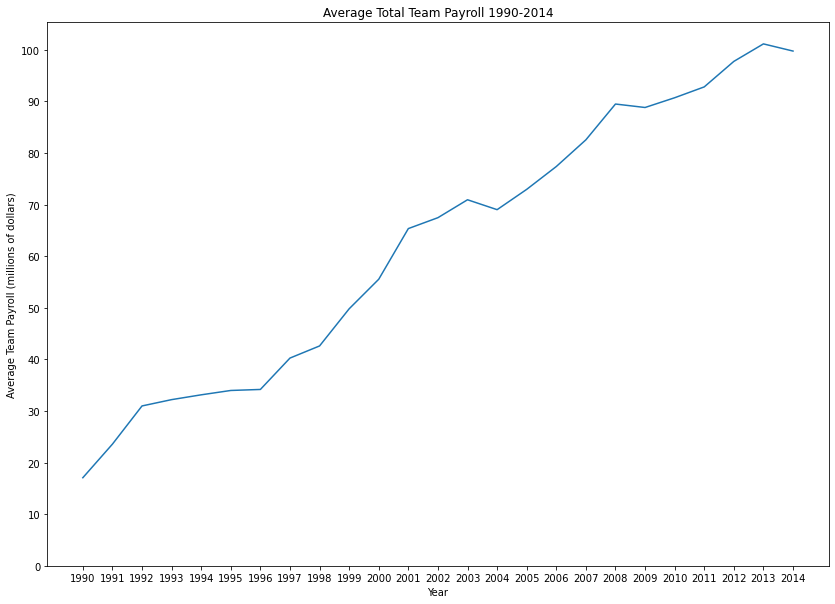

In [276]:
import numpy as np

by_year = team_salaries.groupby('yearID').mean()
avg_payroll = by_year['total_payroll']
years = list(range(1990,2015))
plt.figure(figsize=(14,10))
plt.plot(years, avg_payroll)
plt.title('Average Total Team Payroll 1990-2014')
plt.xlabel('Year')
plt.ylabel("Average Team Payroll (millions of dollars)")
plt.xticks(np.arange(1990,2015,step=1))
plt.yticks(np.arange(0,110e6,step=10e6), list(range(0,110,10)))
plt.show()

The average team payroll has substantially increased during this time frame, from around 17 million dollars to more than 100 million.

Since we already have our time_periods column, we can generate 5 subplots of each team's average win percentage vs. average total payroll during a time period.

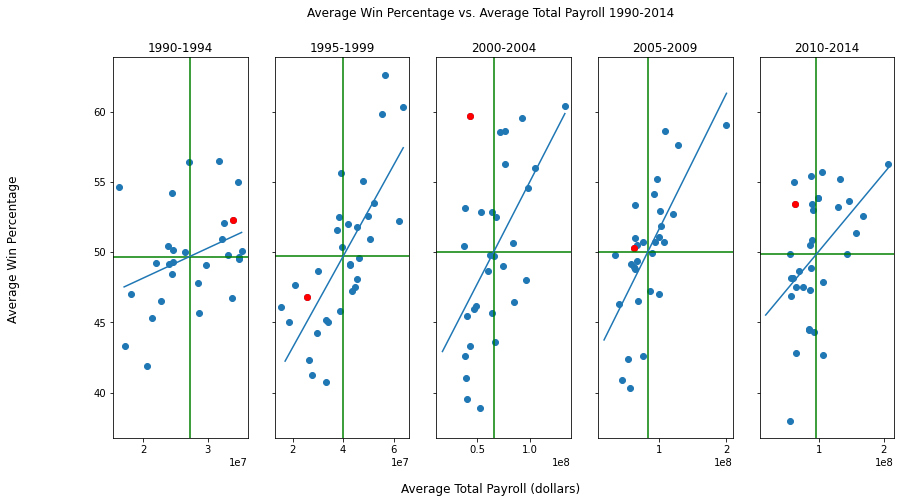

In [277]:
fig, axs = plt.subplots(1, 5, figsize=(14, 7), sharey=True)

fig.suptitle('Average Win Percentage vs. Average Total Payroll 1990-2014')
fig.supxlabel('Average Total Payroll (dollars)')
fig.supylabel('Average Win Percentage')

index = 0

for period in ['1990-1994','1995-1999','2000-2004','2005-2009','2010-2014']:
    sub_df = team_salaries[team_salaries['time_period'] == period]
    sub_df = sub_df.groupby('teamID').mean()
    avg_payroll = sub_df['total_payroll']
    avg_win_percent = sub_df['win_percentage'].fillna(sub_df['win_percentage'].mean())
    sub_df = sub_df.reset_index()
    axs[index].scatter(avg_payroll, avg_win_percent)
    oak_info = sub_df[sub_df['teamID'] == 'OAK']
    axs[index].scatter(oak_info['total_payroll'], oak_info['win_percentage'], color='red')
    axs[index].set_title(period)
    axs[index].axhline(y=avg_win_percent.mean(), color='green')
    axs[index].axvline(x=avg_payroll.mean(), color='green')
    z = np.polyfit(avg_payroll, avg_win_percent, 1)
    p = np.poly1d(z)
    xp = np.linspace(17e6, np.max(avg_payroll), 100)
    axs[index].plot(xp, p(xp))
    index += 1

plt.show()

Note: y-axis tick values are shared by all of the subplots

## Observations

(The red points are the Oakland A's. The green lines represent the average payrolls and win percentages of all the teams during that time period.) In general, the teams that spent more money tended to perform better. This trend is most apparent in the time periods between 1995 and 2009. From 2000 onwards, the Oakland A's tended to spend less than the majority of teams, but performed at or better than average, indicating that the money they invested paid off more (better efficiency).

# Part 3: Data Transformations

Standardize the payrolls conditioned on year.

In [278]:
avg = np.array(team_salaries.groupby('yearID').mean()['total_payroll'])
sd = np.array(team_salaries.groupby('yearID').std()['total_payroll'])

team_salaries['standardized_payroll'] = (team_salaries['total_payroll'] - avg[team_salaries['yearID'] - 1990]) / sd[team_salaries['yearID'] - 1990]
team_salaries.head()

,yearID,teamID,total_payroll,win_percentage,time_period,standardized_payroll
0,1990,ATL,14555501.0,40.12,1990-1994,-0.667275
1,1990,BAL,9680084.0,47.20,1990-1994,-1.959861
2,1990,BOS,20558333.0,54.32,1990-1994,0.924213
3,1990,CAL,21720000.0,49.38,1990-1994,1.232198
4,1990,CHA,9491500.0,58.02,1990-1994,-2.009859


Standardized payrolls by time period.

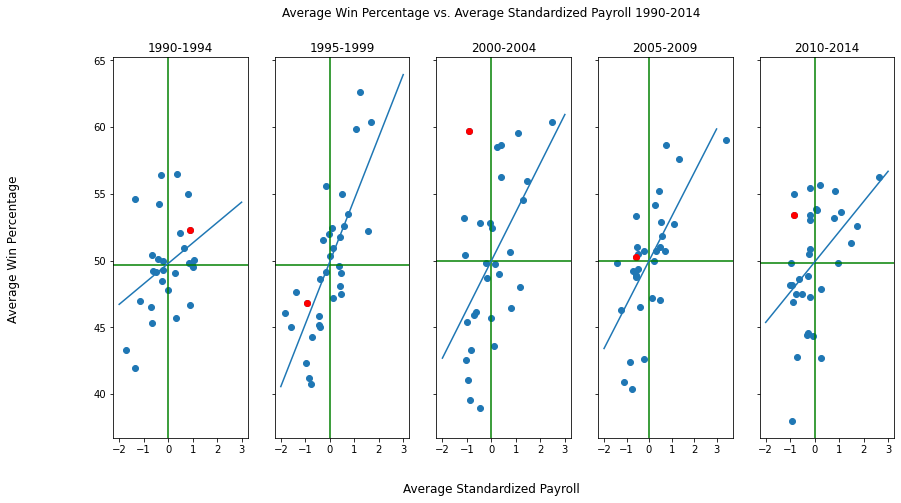

In [286]:
fig, axs = plt.subplots(1, 5, figsize=(14, 7), sharey=True)

fig.suptitle('Average Win Percentage vs. Average Standardized Payroll 1990-2014')
fig.supxlabel('Average Standardized Payroll')
fig.supylabel('Average Win Percentage')

index = 0

for period in ['1990-1994','1995-1999','2000-2004','2005-2009','2010-2014']:
    sub_df = team_salaries[team_salaries['time_period'] == period]
    sub_df = sub_df.groupby('teamID').mean()
    avg_payroll = sub_df['standardized_payroll']
    avg_win_percent = sub_df['win_percentage'].fillna(sub_df['win_percentage'].mean())
    sub_df = sub_df.reset_index()
    axs[index].scatter(avg_payroll, avg_win_percent)
    oak_info = sub_df[sub_df['teamID'] == 'OAK']
    axs[index].scatter(oak_info['standardized_payroll'], oak_info['win_percentage'], color='red')
    axs[index].set_title(period)
    axs[index].set_xticks(np.arange(-2,4,1))
    axs[index].axhline(y=avg_win_percent.mean(), color='green')
    axs[index].axvline(x=0, color='green')
    z = np.polyfit(avg_payroll, avg_win_percent, 1)
    p = np.poly1d(z)
    xp = np.linspace(-2, 3, 100)
    axs[index].plot(xp, p(xp))
    index += 1

plt.show()

## Observations

Without standardizing the payroll, it can be difficult to get a sense of how much a team is spending compared to the other teams. After the transformation on payroll, the data points are now centered around 0 and it shows how much each team deviates from the mean total payroll of its year. Each tick on the x-axis represents one standard deviation away from the mean payroll of a specific year. The plots from problems 4 and 6 look similar because this transformation essentially shifted and rescaled the data points horizontally.

Plot Winning Percentage vs. Standardized Payroll for every team from every year 1990-2014 and calculate a linear regression line.

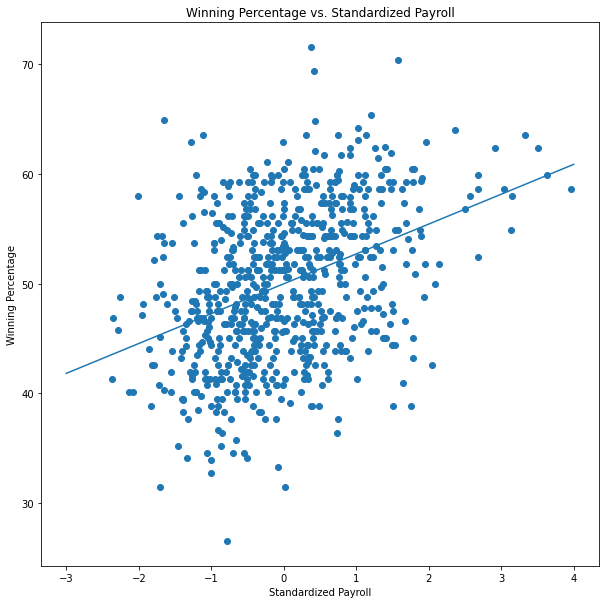

In [282]:
plt.figure(figsize=(10,10))
plt.scatter(team_salaries['standardized_payroll'], team_salaries['win_percentage'])
z = np.polyfit(team_salaries['standardized_payroll'], team_salaries['win_percentage'].fillna(team_salaries['win_percentage'].mean()), 1)
p = np.poly1d(z)
xp = np.linspace(-3, 4, 100)
plt.plot(xp, p(xp))
plt.title('Winning Percentage vs. Standardized Payroll')
plt.xlabel('Standardized Payroll')
plt.ylabel('Winning Percentage')
plt.show()

### Regression Line:

In [283]:
p

poly1d([ 2.72197385, 49.99949176])

### Expected win percentage = 2.72*(standardized payroll) + 50.00

Note: When I did the linear regression including the years before 1985, I did get a slope of around 2.5, but I am following what an instructor said on a Piazza post, which is to only look at the years 1990 and after.

Add an efficiency column, calculated by subtracting a team's win percentage by their expected win percentage based on the linear regression model.

In [284]:
expected_win_percentage = p(team_salaries['standardized_payroll'])
team_salaries['efficiency'] = team_salaries['win_percentage'] - expected_win_percentage
team_salaries.head()

,yearID,teamID,total_payroll,win_percentage,time_period,standardized_payroll,efficiency
0,1990,ATL,14555501.0,40.12,1990-1994,-0.667275,-8.063185
1,1990,BAL,9680084.0,47.20,1990-1994,-1.959861,2.535198
2,1990,BOS,20558333.0,54.32,1990-1994,0.924213,1.804824
3,1990,CAL,21720000.0,49.38,1990-1994,1.232198,-3.973502
4,1990,CHA,9491500.0,58.02,1990-1994,-2.009859,13.491291


Plot line charts for 5 teams and observe their spending efficiencies over time.

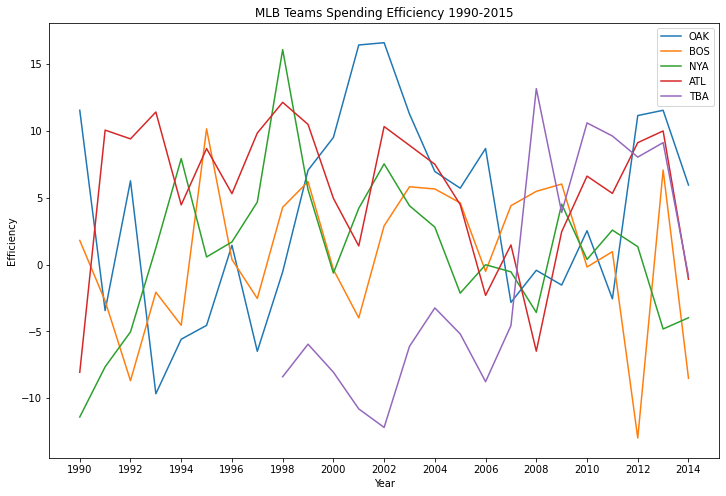

In [285]:
plt.figure(figsize=(12,8))

for team in ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']:
    sub_df = team_salaries[team_salaries['teamID'] == team]
    plt.plot(sub_df['yearID'], sub_df['efficiency'])

plt.title('MLB Teams Spending Efficiency 1990-2015')
plt.xlabel('Year')
plt.ylabel('Efficiency')
plt.legend(labels=['OAK', 'BOS', 'NYA', 'ATL', 'TBA'])
plt.xticks(np.arange(1990,2016,step=2))
plt.show()

## Observations

This plot demonstrates how a team's performance during a year compares to their expected performance given the amount of money they've spent. If the efficiency was at zero percent, then the team performed at the expected level according to the linear regression. If it was higher or lower, then the team exceeded or did not meet their expected performance. Oakland's spending efficiency was lower than that of the other teams between 1993-2000. During the Moneyball period (2000-2005), Oakland's spending efficiency was significantly higher than that of the other teams (peaked from 2002-2003). After 2006, it was roughly the same, which makes sense because other teams likely learned from their strategy and caught up with them then. Note: data for Tampa Bay is only available from 1998 onwards.